In [ ]:
import matplotlib.pyplot as plt
import pickle
from os.path import join
import scipy.stats as st
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

Mounted at /content/drive/


In [ ]:
#@title Mouse class { form-width: "300px" }
import pandas as pd
import numpy as np
from scipy import interpolate, signal
import math
from scipy.stats import kstest
import copy
 
#from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
 
class Mouse():
 
    def __init__(self, name, session, day, time_shift, build_spikes, xc, yc,
                 path_track, path_neuro, path_spatial_info, **kwargs):
        
        self.name = name
        self.session = session
        self.day = day
        self.dtypef = np.float32
        self.time_shift = time_shift
        self.start_trim = 10
        self.end_trim = 10
 
        
        xy_delim = ' '
        xy_sk_rows = 1
        xy_sk_cols = 0
        if 'xy_delim' in kwargs:
            xy_delim = kwargs['xy_delim']    
        if 'xy_sk_rows' in kwargs:
            xy_sk_rows = kwargs['xy_sk_rows'] 
        if 'xy_sk_cols' in kwargs:
            xy_sk_cols = kwargs['xy_sk_cols']
             
        self.get_xy_data(path_track, path_neuro, xc, yc, xy_delim, xy_sk_rows, xy_sk_cols)
        
        if build_spikes:
            self.build_spikes()
        elif 'path_spikes' in kwargs:
            self.get_spike_data(kwargs['path_spikes'])       
        
        self.get_angle()
        self.trim_data()
        
        try:
            SI_data = pd.read_csv(path_spatial_info)
            #SI_data = SI_data.astype(object).replace(np.nan, 'None')
 
            self.spatial_info = SI_data['spatial_info'].values
            self.rand_spatial_info = SI_data['rand_spatial_info'].values
            self.rand_spatial_info_std = SI_data['rand_spatial_info_std'].values
            self.cell_z_score = np.array([np.nan for _ in range(self.n_cells)])
            for i in range(self.n_cells):
                try:
                    self.cell_z_score[i] = (self.spatial_info[i] - self.rand_spatial_info[i])/self.rand_spatial_info_std[i]
                except:
                    pass
 
        except:
        
            print('Spatial info data not found, calculating SI from scratch...')
            self.spatial_info = np.array([np.nan for _ in range(self.n_cells)])
            self.rand_spatial_info = np.array([np.nan for _ in range(self.n_cells)])
            self.rand_spatial_info_std = np.array([np.nan for _ in range(self.n_cells)])
        
    def get_xy_data(self, path_track, neuro_path, xc, yc, delimiter = ' ', skip_rows = 1, skip_cols = 0):
        w = 21
        time_massive = []
        x_massive = []
        y_massive = []
        self.x = []
        self.y = []
        self.v = []
        self.vx = []
        self.vy = []
        self.xc = xc
        self.yc = yc
       
        tr = np.genfromtxt(path_track, delimiter=delimiter, skip_header=skip_rows)
        time_massive = tr[:,0]
        x_massive = tr[:,1+skip_cols]
        y_massive = tr[:,2+skip_cols]
        
        #pre-filtering
        x_massive = signal.medfilt(x_massive, 11)
        y_massive = signal.medfilt(y_massive, 11)
        
        #removing NaN values
        valid_indices = ~np.isnan(x_massive) * ~np.isnan(y_massive)
        time_massive = time_massive[valid_indices]
        x_massive = x_massive[valid_indices]
        y_massive = y_massive[valid_indices] 
 
        #interp to 20 fps        
        fx = interpolate.interp1d(time_massive, x_massive)
        fy = interpolate.interp1d(time_massive, y_massive)
        self.time = list(range(int(time_massive[0]*20)+1, int(time_massive[-1]*20)))
        for i in range(len(self.time)):
            self.time[i] *= 0.05
            self.x.append(fx(self.time[i]))
            self.y.append(fy(self.time[i]))
        
        #smoothing with 1-s window average filter
        self.x = np.convolve(self.x, np.ones(w)/w, mode='same')
        self.y = np.convolve(self.y, np.ones(w)/w, mode='same')
        
        #speed
        for i in range(1, len(self.x)):
            self.v.append(round(np.sqrt((self.x[i] - self.x[i-1])**2 + (self.y[i] - self.y[i-1])**2)/(self.time[i]-self.time[i-1]), 3))
            self.vx.append(round((self.x[i] - self.x[i-1])/(self.time[i]-self.time[i-1]), 3))
            self.vy.append(round((self.y[i] - self.y[i-1])/(self.time[i]-self.time[i-1]), 3))
            
        self.min_time_trace = self.time[0]
        shift_sp_rows = int(round((self.min_time_trace - self.time_shift)*20))
        t_size = len(self.time)
 
        #neural activity
        neur = np.genfromtxt(neuro_path, delimiter=',', skip_header=shift_sp_rows, max_rows=t_size, dtype=self.dtypef, comments='None')
        self.neur = neur[:, 1:]
        
        self.n_cells = len(self.neur[0])
        self.n_frames = len(self.neur)
        self.pc_mask = None
 
        self.x = self.x[0:self.n_frames]
        self.y = self.y[0:self.n_frames] 
 
        self.scx = (self.x-min(self.x))/(max(self.x)-min(self.x))-0.000001
        self.scy = (self.y-min(self.y))/(max(self.y)-min(self.y))-0.000001
 
        if self.xc == None or self.yc == None:
            start = self.start_trim
            end = self.end_trim
            self.xc = (min(self.scx[start:-end])+max(self.scx[start:-end]))/2
            self.yc = (min(self.scy[start:-end])+max(self.scy[start:-end]))/2
 
        self.v = np.array(self.v[0:self.n_frames])
        self.vx = np.array(self.vx[0:self.n_frames])
        self.vy = np.array(self.vy[0:self.n_frames])
        self.time = np.array(self.time[0:self.n_frames])
 
    def get_spike_data(self, spike_path):
        shift_sp_rows = int(round((self.min_time_trace - self.time_shift)*20))
        t_size = len(self.time)
        sp = np.genfromtxt(spike_path, delimiter=',', skip_header=shift_sp_rows, max_rows=t_size, dtype=self.dtypef, comments='None')
        self.spikes = sp[:, 1:]
        self.smoothed_spikes = copy.deepcopy(self.spikes)
        self.spikes_count = np.sum(self.spikes.astype(bool).astype(int), axis = 0)
        '''
        for i in range(1,10):
            #print(sum(self.smoothed_spikes[:,0]))
            self.smoothed_spikes += np.roll(copy.deepcopy(self.spikes), i, axis=0)
        '''
    def build_spikes(self):
        pass
 
    def get_angle(self):
        self.angle = []
        xc, yc = self.xc, self.yc
        
        for i in range(len(self.scx)):
            self.angle.append(180 + round((math.degrees(math.atan2(self.scy[i] - yc, self.scx[i] - xc))),3))
        self.angle = np.array(self.angle)  
 
    def get_direction(self):
         der = np.ediff1d(self.angle, 0)
         der[der <= -90] += 360
         der[der >= 90] -= 360
         self.direction = np.sign(der)
 
    def get_acceleration(self):
        w = 35
        sp = np.convolve(self.v, np.ones(w)/w, mode='same')
        self.acceleration = np.gradient(sp, 0.05, edge_order=2)
        
    def get_binned_neuro(self, Nbins):
        self.neuro_bin = np.zeros(self.neur.shape, dtype = int)
        for i in range(self.neur.shape[1]):
            ma = np.max(self.neur[:,i])
            mi = np.min(self.neur[:,i])
            self.neuro_bin[:,i] = (self.neur[:,i] - mi)*Nbins/(ma-mi)
        self.neuro_bin[self.neuro_bin == Nbins] -= 1
 
    def get_shuffled_neuro(self, n):
        self.shuffled_neur = np.zeros(((self.n_frames//n)*n, self.n_cells))
 
        for i in range(self.n_cells):
            ts = self.neur[:,i]
            #chunks = np.concatenate((np.split(ts[:(len(ts)//n)*n], n), ts[(len(ts)//n)*n:]))
            chunks = np.split(ts[:(len(ts)//n)*n], n)
            inds = np.arange(n)
            np.random.shuffle(inds)
 
            self.shuffled_neur[:,i] = np.concatenate(tuple(np.array(chunks)[inds]))
            
    def trim_data(self):
 
        start = self.start_trim
        end = self.end_trim
 
        self.x = self.x[start:-end]
        self.y = self.y[start:-end]
        self.scx = self.scx[start:-end]
        self.scy = self.scy[start:-end]
 
        self.time = self.time[start:-end]
        self.v = self.v[start:-end]
        self.vx = self.vx[start:-end]
        self.vy = self.vy[start:-end]
        self.angle = self.angle[start:-end]
 
        self.spikes = self.spikes[start:-end]
        self.smoothed_spikes = self.smoothed_spikes[start:-end]
        self.neur = self.neur[start:-end]
 
    def trajectory(self, points = None, colors = None):
        fig, ax = plt.subplots(figsize = (12,12))
        if colors is None:
            colors = range(len(ms.scx))
        
        if points is None:
            ax.scatter(ms.scx, ms.scy, c = colors)
        else:
            ax.scatter(ms.scx[points], ms.scy[points], c = colors)
 
def TrimTime(Mouse, t_end):
    if  Mouse.n_frames >= int((t_end - Mouse.time[0])*20):   
        Mouse.n_frames = int((t_end - Mouse.time[0])*20)
    else:
        raise ValueError   
 
    fr_end = Mouse.n_frames - 1
    Mouse.time = Mouse.time[0:fr_end]
    Mouse.angle = Mouse.angle[0:fr_end]
    Mouse.spikes = Mouse.spikes[0:fr_end,:]
    Mouse.neur = Mouse.neur[0:fr_end,:]
    Mouse.neuro_bin = Mouse.neuro_bin[0:fr_end,:]
    return Mouse
 
def GetRears(Mouse, rear_fname):
    rr = np.genfromtxt(rear_fname, delimiter=',', skip_header=0)
    fr = interpolate.interp1d(rr[:,0], rr[:,1])
    Mouse.rear = [np.sign(fr(t)) for t in Mouse.time]
    return Mouse
 
def RearStat(Mouse, n_sup, cell):
    rear_t_inz = []
    n_spec = 0
    for i, ti in enumerate(Mouse.times_in[cell]):
        if (i==0 or i>=1 and Mouse.t_spec[n_sup][0] >= Mouse.times_out[cell][i-1])  and Mouse.t_spec[n_sup][0] <= Mouse.times_out[cell][i]:
            n_spec = i
        rear_t_inz.append(np.sum(np.abs(Mouse.rear[ti:Mouse.times_out[cell][i]]))/(Mouse.times_out[cell][i]-ti))
    if n_spec:
        rear_t_bef = sum(rear_t_inz[:n_spec])/n_spec
    else:
        rear_t_bef = 0   
    rear_t_aft = sum(rear_t_inz[n_spec:])/(len(rear_t_inz) - n_spec)
    return rear_t_inz, rear_t_bef, rear_t_aft

In [ ]:
#@title Data loading { form-width: "300px" }
DATANAME = 'CA1_'+str(22)+'_HT'+str(1)
PATH = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'
T_RISE = 15
T_OFF = 40

def load_neurodata(start, stop, norm = 1):

    picklefile = open(join(PATH, DATANAME), 'rb')
    ms = pickle.load(picklefile)
    picklefile.close()

    indices_to_take = np.where(ms.v > 0)[0]
    sp_d = ms.spikes.T[ms.pc_mask, :]
    sp_data = sp_d[:,indices_to_take][:,start:stop]
    neur_d = ms.neur.T[ms.pc_mask, :]
    neur_data = neur_d[:,indices_to_take][:,start:stop]

    cells_with_spikes = np.nonzero(np.sum(sp_data, axis = 1))[0]
    spdata = sp_data[cells_with_spikes, :]
    cadata = neur_data[cells_with_spikes, :]

    if norm:
        scaler = MinMaxScaler()
        spdata = scaler.fit_transform(spdata.T).T
        cadata = scaler.fit_transform(cadata.T).T

    return spdata, cadata


In [ ]:
#@title Cell similarity { form-width: "300px" }


def spike_form(t):
    return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)


def calc_spike_similarity(data, start, end, thr = 0):
    x = np.linspace(0, 100, num = 100)
    sp = spike_form(x)

    sim = np.zeros((len(data), len(data)))
    spform_data = data.copy()
    for i in range(len(spform_data)):
        spform_data[i,:] = np.convolve(data[i,:], sp)[:end-start]

    for i in range(len(spform_data)):
        y1 = spform_data[i,:].copy()
        
        for j in range(i+1, len(spform_data)):
            y2 = spform_data[j,:].copy()
            mod1 = np.sqrt(np.dot(y1,y1))
            mod2 = np.sqrt(np.dot(y2,y2))
            if mod1 != 0 and mod2 != 0:
                similarity = np.dot(y1,y2)/(mod1*mod2)
            else:
                similarity = 0

            sim[i,j] = similarity
            sim[j,i] = similarity

    #plot_mat(sim)
    #np.nan_to_num(sim)
    sim[sim<thr] = 0

    return sim/np.max(sim)

In [ ]:
#@title Launch { form-width: "300px" }

start = 1000
stop = 2000

spdata, cadata = load_neurodata(start, stop, norm = 0)
sim = calc_spike_similarity(spdata, start, stop, thr = 0)

# Новый раздел

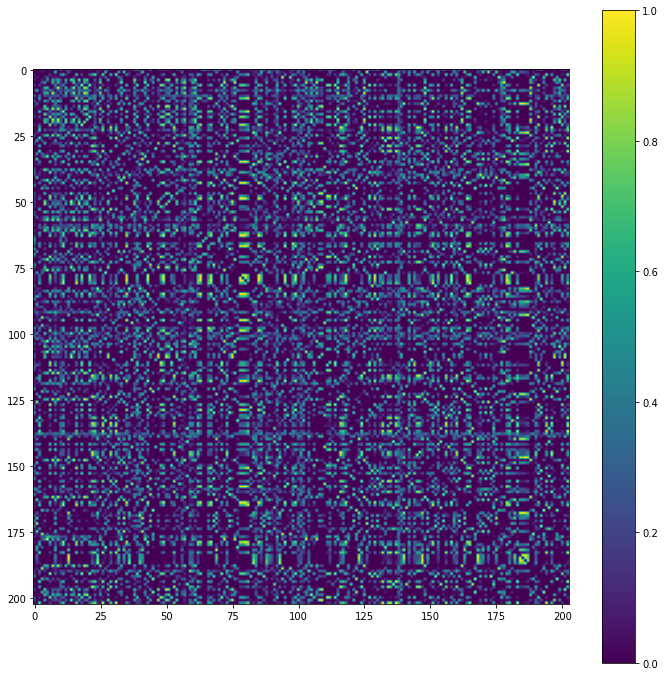

In [ ]:
def plot_mat(mat):
    fig, ax = plt.subplots(figsize = (12, 12))
    #change_labels_color(ax)
    im = ax.imshow(mat)
    cbar = ax.figure.colorbar(im, ax=ax)

plot_mat(sim)

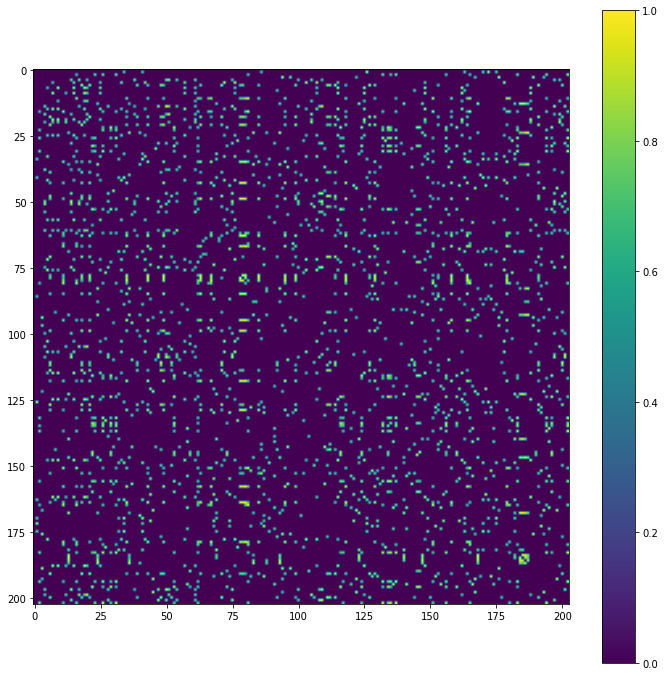

In [ ]:
sim[sim<0.7] = 0
plot_mat(sim)

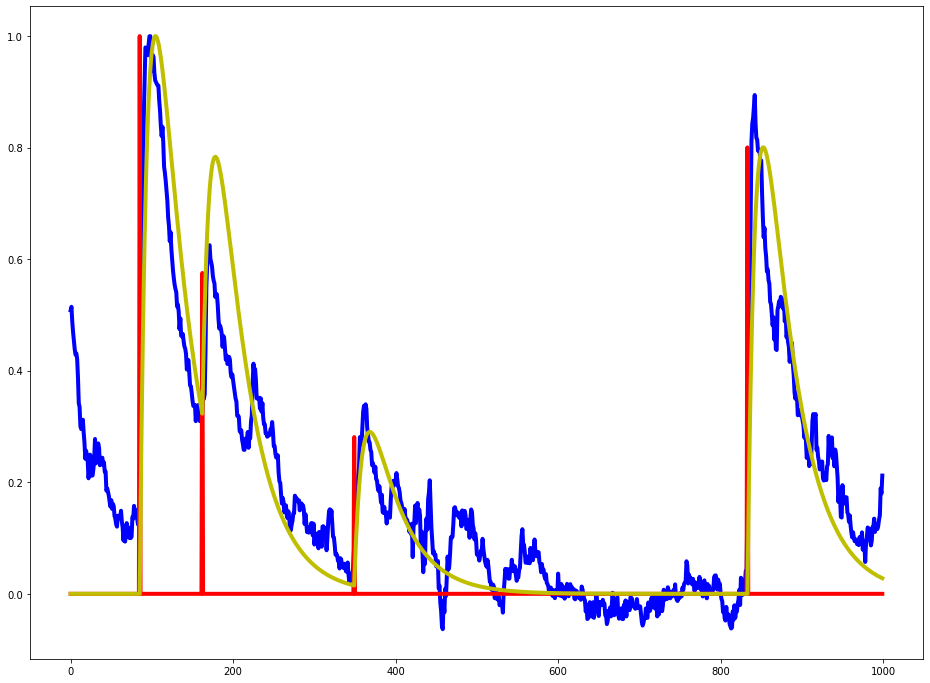

In [ ]:
x = np.linspace(0, 400, num = 400)
sp = spike_form(x)
denoised_data = spdata.copy()
denoised_data[0,:] = np.convolve(spdata[0,:], sp)[:-400+1]

fig, ax = plt.subplots(figsize = (16,12))
ax.plot(cadata[0]/max(cadata[0]), c = 'b', linewidth = 4)
ax.plot(spdata[0]/max(spdata[0]), c = 'r', linewidth = 4)
ax.plot(denoised_data[0]/max(denoised_data[0]), c = 'y', linewidth = 4)